# Example 5.1: AR(1)-Model with uncertainty w.r.t. $\mu$

First, include the necessary functions.
The linear programming solver requires the gurobi package!

In [1]:
source(file="functions.r")

Warning message:
"package 'linprog' was built under R version 3.6.2"Loading required package: lpSolve
Warning message:
"package 'lpSolve' was built under R version 3.6.2"Warning message:
"package 'gurobi' was built under R version 3.6.2"Loading required package: slam
Warning message:
"package 'slam' was built under R version 3.6.2"

We define a function to simulate an AR(1) model

In [2]:
AR_1<-function(t=0.1,N=10000,mu=100,k=0.1,sigma=20,plot=T,plot_threshold=2*sigma,S_0=100){
  norm_rv<-rnorm(N,mean=0,sd=t*sigma)
  #  norm_rv<-rep(1,N)
  Y<-numeric(N)
  Y[1]<-S_0
  for(i in 2:N){
    Y[i]<-Y[i-1]+k*(mu-Y[i-1])*t+norm_rv[i]
  }
  if(plot){
    plot(1:N,Y,type='l',col="black",lwd=0.5,xlab="Time",ylab="Spread")
    abline(h=mu+plot_threshold,lty=2)
    abline(h=mu,lty=2)
    abline(h=mu-plot_threshold,lty=2)
  }
  return(Y)
  
}

We assign the parameters $S_{t_0}=0$, $n=100$, $\overline{t}=1$ $\sigma = 1$ (modelled here through a constant sequence), $\kappa = 0.001$ (also a sequence). We assume $\mu \in [-1,1]$ and that we consider $10$ different values of $\mu$ as well as that the probability measures are supported on $50$ values.

In [3]:
S_0<-0
n<-100 # time steps 
N<-10 # different Parameters
kk<-rep(0.001,N)
mu<-seq(-1,1,length=N)
sigma<-seq(1,1,length=N)
time_diff<-1
n_discr<-50

We discretize the underlying space, assign probablities associated to the model, remove too low probabilities and plot one density (associated to $\mu = -1$).

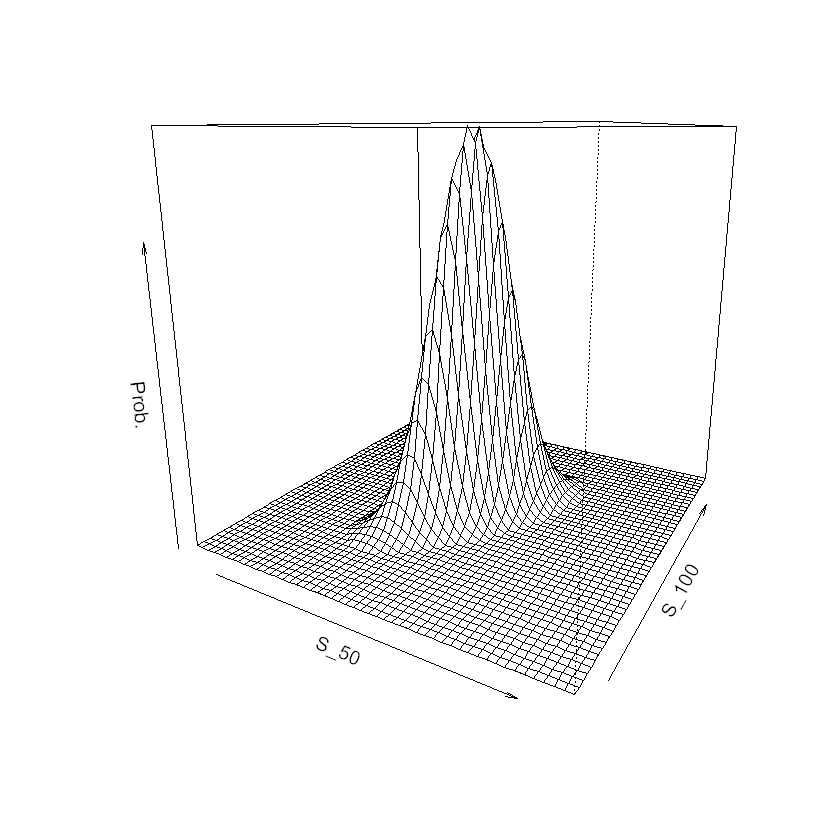

In [4]:
## Values
x<-matrix(0,N,n_discr)
y<-matrix(0,N,n_discr)
standard_dev<-0
for(j in 0:(n/2)){
  standard_dev<-standard_dev+((1-kk*time_diff)^j)*sigma*time_diff
}
standard_dev<-sqrt(standard_dev)

# probabilities
prob_set<-array(0,dim=c(N,n_discr,n_discr))
for(i in 1:N){
  # Assigning Values
  x[i,]<-seq(S_0-50,S_0+50,length=n_discr)
  y[i,]<-seq(S_0-50,S_0+50,length=n_discr)
  for(j in 1:n_discr){
    for(k in 1:n_discr){
      # Assigning Probabilities
      prob_set[i,j,k]<-dnorm(x[i,j],mean=mu[i]*(1-(1-kk[i]*time_diff)^(n/2))+((1-kk[i]*time_diff)^(n/2))*S_0,sd=standard_dev[i])*dnorm(y[i,k],mean=mu[i]*(1-(1-kk[i]*time_diff)^(n/2))+((1-kk[i]*time_diff)^(n/2))*x[i,j],sd=standard_dev[i])
    }
  }
  prob_set[i,,]<-prob_set[i,,]/sum(prob_set[i,,])
}

### Removing too low probabilities
epsilon<-0.0001
for(i in 1:N){
  for(j in 1:n_discr){
    for(k in 1:n_discr){
      if((prob_set[i,j,k])<epsilon){
        prob_set[i,j,k]<-0
      }
    }
  }
  prob_set[i,,]<-prob_set[i,,]/sum(prob_set[i,,])
}

persp(x[1,],y[1,],prob_set[1,,],xlab="S_50",ylab="S_100",zlab="Prob.",theta=30)

We simulate one AR(1) - instance and plot it, we exclude statistical arbitrage, define our spread option $\max(S_{t_{100}}-S_{t_0},0)$ and compute robust price bounds for the spread options

[1] "No Statistical Arbitrage!"


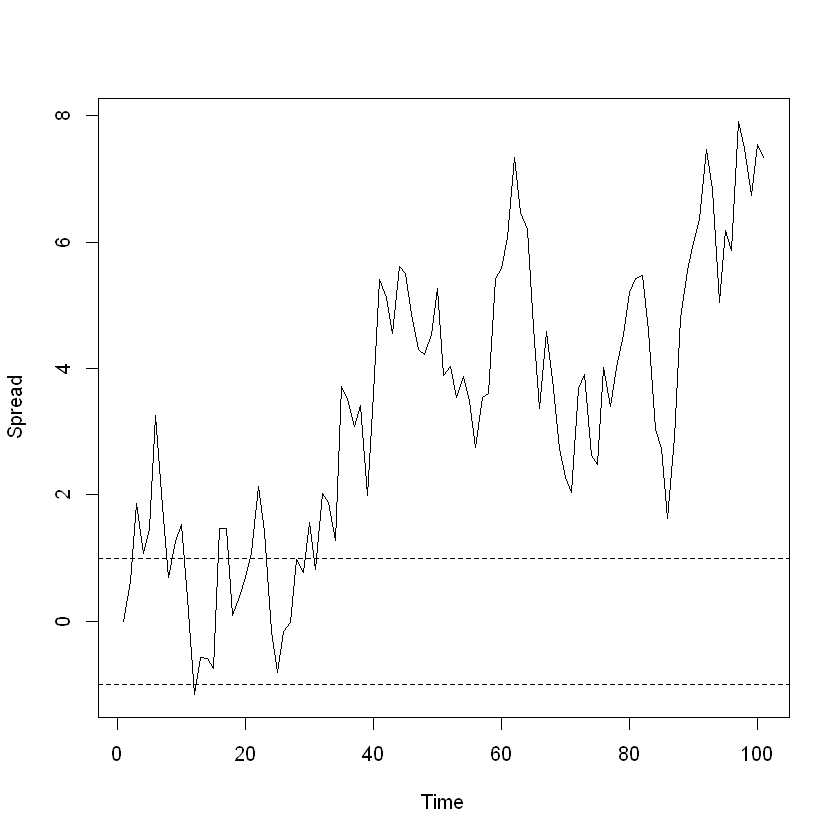

In [5]:
ar_1<-AR_1(t=time_diff,N=n+1,mu=mu[1],k=kk[1],sigma=sigma[1],plot=T,plot_threshold=2*sigma[1],S_0=S_0)
func1<-function(x,y){max(y-S_0,0)}
# Computation of the Bounds
limit<-Inf
# Robust Bounds
check_statarb(x[1,],y[1,],prob_set[1,,],S_0)
lower_bound_nosa<-super_rep(x,y,prob_set,func=func1,stat_arb=F,lower=T,S_0,limit)
lower_bound<-super_rep_robust(x,y,prob_set,func=func1,stat_arb=T,lower=T,S_0,limit)
upper_bound<-super_rep_robust(x,y,prob_set,func=func1,stat_arb=T,lower=F,S_0,limit)
upper_bound_nosa<-super_rep(x,y,prob_set,func=func1,stat_arb=F,lower=F,S_0,limit)

The no robust arbitrage price interval

In [6]:
print(lower_bound_nosa$d)
print(upper_bound_nosa$d)

[1] 0.5102041
[1] 25


The no robust statistical arbitrage price interval

In [7]:
print(lower_bound$d)
print(upper_bound$d)

[1] 3.995407
[1] 4.042145


Next, we define the delta-strategies associated to pairs trading

In [8]:
########## Delta Strategies
Delta_strat<-function(N,eps=20,delta=0.001,Y,mu=0){
  Delta<-numeric(N)
  for(i in 2:N){
    if((Y[i]>=(mu+eps))*(Delta[i-1]==0)){
      Delta[i]<-(Delta [i-1]-1)
    }
    else if((Y[i]>=(mu-delta))*(Delta[i-1]==1)){
      Delta[i]<-(Delta [i-1]-1)
    }
    else if((Y[i]<=(mu-eps))*(Delta[i-1]==0)){
      Delta[i]<-(Delta [i-1]+1)
    }
    else if((Y[i]<=(mu+delta))*(Delta[i-1]==(-1))){
      Delta[i]<-(Delta [i-1]+1)
    }
    else{
      Delta[i]<-(Delta [i-1])
    }
  }
  return(Delta)
}
Gain<-function(Delta,N,S){
  G<-numeric(N)
  for(i in 2:N){
    G[i]<-Delta[i-1]*(S[i]-S[i-1])
  }
  G<-cumsum(G)
  # print(G[N])
  return(G)
    }

We assume $c$ is traded for price $6$ and simulate the profit of the statistical arbtirage strategy

In [9]:
## Statistical Arbitrage
Delta_0_upper<-upper_bound$Delta_0
Delta_1_upper<-splinefun(upper_bound$x,upper_bound$Delta_1,method="natural")
#plot(upper_bound$x,Delta_1_upper(upper_bound$x),type="l")
nr_gains<-0
nr_losses<-0
d_upper<-upper_bound$d
gain<-0
Nr_sim<-1000000
best<-0
worst<-0
ff1<-numeric(Nr_sim)
for(i in 1:Nr_sim){
  ii<-sample(1:N,1) # choosing random parameter
  S<-AR_1(t=time_diff,N=n+1,mu=mu[ii],k=kk[ii],sigma=sigma[ii],plot=F,plot_threshold=2*sigma,S_0=S_0)
  f<-(6-func1(S[n/2],S[n])+Delta_0_upper*(S[n/2]-S_0)+Delta_1_upper(S[n/2])*(S[n]-S[n/2]))
  ff1[i]<-f
  gain<-gain+f
  if(f<0){nr_losses<-nr_losses+1}
  if(f>0){nr_gains<-nr_gains+1}
  if(f>best){best<-f}
  if(f<worst){worst<-f}
}
print("Average Profit")
gain/Nr_sim
print("Best Gain")
best
print("Worst Loss")
worst
print("% Loss Scenarios")
nr_losses/Nr_sim
print("% Gain Scenarios")
nr_gains/Nr_sim

[1] "Average Profit"


[1] 2.068416

[1] "Best Gain"


[1] 521.8673

[1] "Worst Loss"


[1] -513.557

[1] "% Loss Scenarios"


[1] 0.299286

[1] "% Gain Scenarios"


[1] 0.700714

We simulate the profit of the pairs trading strategy with $\varepsilon = \sigma$.

In [10]:
#1)epsilon=sigma

nr_gains<-0
nr_losses<-0
gain<-0
Nr_sim<-1000000
best<-0
worst<-0
ff2<-numeric(Nr_sim)
for(i in 1:Nr_sim){
  ii<-sample(1:N,1) # choosing random parameter
  S<-AR_1(t=time_diff,N=n+1,mu=mu[ii],k=kk[ii],sigma=sigma[ii],plot=F,plot_threshold=2*sigma[ii],S_0=S_0)
  D1<-Delta_strat(N=n+1,eps=1*sigma[ii],delta=0.001,S,mu[ii])
  f<-Gain(D1,(n+1),S)[n+1]
  ff2[i]<-f
  gain<-gain+f
  if(f<0){nr_losses<-nr_losses+1}
  if(f>0){nr_gains<-nr_gains+1}
  if(f>best){best<-f}
  if(f<worst){worst<-f}
}
print("Average Profit")
gain/Nr_sim
print("Best Gain")
best
print("Worst Loss")
worst
print("% Loss Scenarios")
nr_losses/Nr_sim
print("% Gain Scenarios")
nr_gains/Nr_sim

[1] 0.5115342

[1] 40.96949

[1] -43.52332

[1] 0.469513

[1] 0.530487

We simulate the profit of the pairs trading strategy with $\varepsilon = 2\sigma$.

In [11]:
#2)epsilon=2*sigma

nr_gains<-0
nr_losses<-0
gain<-0
Nr_sim<-1000000
best<-0
worst<-0
ff3<-numeric(Nr_sim)
for(i in 1:Nr_sim){
  ii<-sample(1:N,1) # choosing random parameter
  S<-AR_1(t=time_diff,N=n+1,mu=mu[ii],k=kk[ii],sigma=sigma[ii],plot=F,plot_threshold=2*sigma[ii],S_0=S_0)
  D1<-Delta_strat(N=n+1,eps=2*sigma[ii],delta=0.001,S,mu[ii])
  f<-Gain(D1,(n+1),S)[n+1]
  gain<-gain+f
  ff3[i]<-f
  if(f<0){nr_losses<-nr_losses+1}
  if(f>0){nr_gains<-nr_gains+1}
  if(f>best){best<-f}
  if(f<worst){worst<-f}
}
print("Average Profit")
gain/Nr_sim
print("Best Gain")
best
print("Worst Loss")
worst
print("% Loss Scenarios")
nr_losses/Nr_sim
print("% Gain Scenarios")
nr_gains/Nr_sim


[1] 0.4990059

[1] 34.41785

[1] -49.39018

[1] 0.459759

[1] 0.540241

We simulate the profit of the pairs trading strategy with $\varepsilon = 3\sigma$.

In [12]:
#3) epsilon=3*sigma

nr_gains<-0
nr_losses<-0
gain<-0
Nr_sim<-1000000
best<-0
worst<-0
ff4<-numeric(Nr_sim)
for(i in 1:Nr_sim){
  ii<-sample(1:N,1) # choosing random parameter
  S<-AR_1(t=time_diff,N=n+1,mu=mu[ii],k=kk[ii],sigma=sigma[ii],plot=F,plot_threshold=2*sigma[ii],S_0=S_0)
  D1<-Delta_strat(N=n+1,eps=3*sigma[ii],delta=0.001,S,mu[ii])
  f<-Gain(D1,(n+1),S)[n+1]
  ff4[i]<-f
  gain<-gain+f
  if(f<0){nr_losses<-nr_losses+1}
  if(f>0){nr_gains<-nr_gains+1}
  if(f>best){best<-f}
  if(f<worst){worst<-f}
}
print("Average Profit")
gain/Nr_sim
print("Best Gain")
best
print("Worst Loss")
worst
print("% Loss Scenarios")
nr_losses/Nr_sim
print("% Gain Scenarios")
nr_gains/Nr_sim

[1] 0.4620575

[1] 32.28498

[1] -42.78574

[1] 0.451455

[1] 0.548446

We plot the histograms

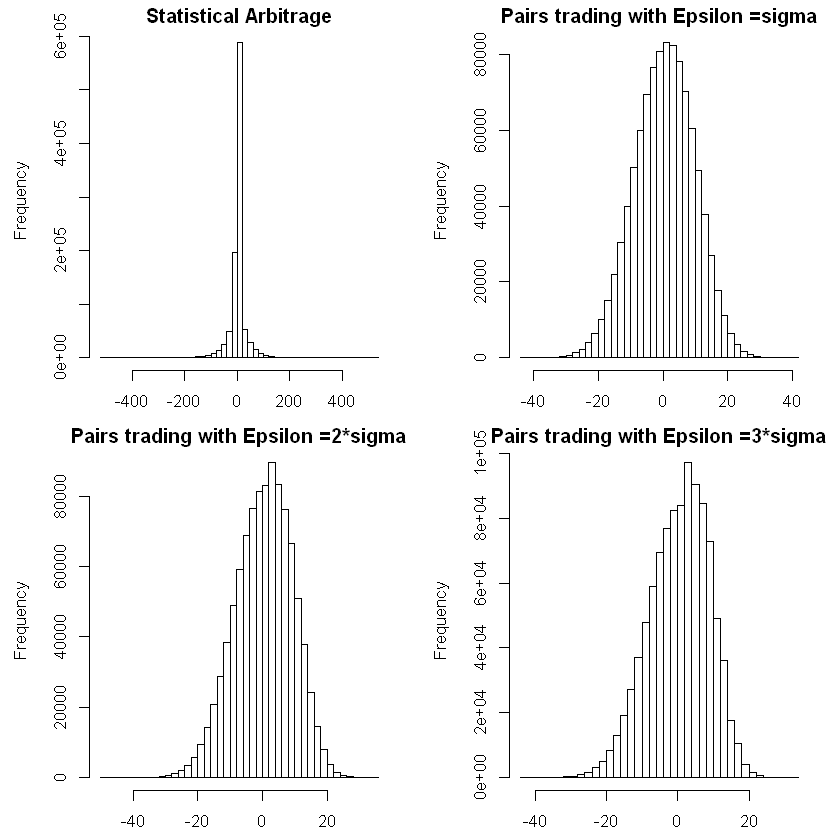

In [14]:
par(mfrow=c(2,2))
par(mar=c(2.5, 4.5,1.5, 1.5))
hist(ff1,xlab="Average Gain",main="Statistical Arbitrage",breaks=50)
hist(ff2,xlab="Average Gain",main="Pairs trading with Epsilon =sigma",breaks=50)
hist(ff3,xlab="Average Gain",main="Pairs trading with Epsilon =2*sigma",breaks=50)
hist(ff4,xlab="Average Gain",main="Pairs trading with Epsilon =3*sigma",breaks=50)